In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

In [2]:
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [3]:
data.train_mask.sum().item() # train_mask denotes against which nodes to train (140 nodes)
data.val_mask.sum().item() # val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes)
data.test_mask.sum().item() # test_mask denotes against which nodes to test (1000 nodes).

1000

In [11]:
dct={}
for c in data.y[data.train_mask].numpy():
    if c in dct:
        dct[c] += 1
    else:
        dct[c] = 1
print(dct)

In [2]:
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

class GCN(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, size_gcn, p_dropout):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(num_features, hidden_channels))

        for i in range(size_gcn):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        # add dropout layer
        self.dropout = nn.Dropout(p=p_dropout)

        self.convs.append(GCNConv(hidden_channels, num_classes))

        self.act = F.leaky_relu

     # Model with leading dropout
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = self.dropout(x)
            x = conv(x, edge_index)

            if conv != self.convs[-1]:
                x = self.act(x)

        return F.softmax(x, dim=1)

In [40]:
import optuna
from optuna.pruners import SuccessiveHalvingPruner, NopPruner
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
import numpy as np

n_trails = 100
n_jobs = 5 # Number of parallel jobs

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [16,32,64,128,256])
    size_gcn = trial.suggest_categorical('hidden_layers', [0,1,2])
    p_dropout = trial.suggest_float('p_dropout', 0.1, 0.7)
    #batch_size=trial.suggest_categorical('batch_size', [16,32,64,128,256])
    batch_size=trial.suggest_categorical('batch_size', [120])
    epochs = trial.suggest_categorical('epochs', np.arange(10,130,10).tolist())
    #optimizer = trial.suggest_categorical('optimizer', [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam])
    optimizer = trial.suggest_categorical('optimizer', [RMSprop])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    
    data = dataset[0]
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = GCN(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, size_gcn=size_gcn,p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay,momentum=0.9) #for RMSprop

    for epoch in range(1, epochs+1):
        for data in loader:
            criterion=nn.CrossEntropyLoss()
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            trial.report(loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Validate model
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Only consider validation data
    true_labels = data.y[data.val_mask].numpy()
    predicted_labels = pred[data.val_mask].numpy()

    # AUC for each class
    auc_list = []
    for i in range(probas.size(1)):
        try:
            auc_list.append(roc_auc_score((true_labels == i).astype(int), probas[data.val_mask, i].detach().numpy()))
        except ValueError:
            pass   
    avg_auc = sum(auc_list) / len(auc_list)

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average

    # Acuracy
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    print(f'Validation Accuracy: {acc * 100:.2f}%')
    
    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GCN_CiteSeer_test_results03.csv', 'a') as f:
        optimizer_name=optimizer.__class__.__name__
        f.write(f'{batch_size}, {hidden_channels},{size_gcn}, {lr}, {weight_decay}, {epochs}, {p_dropout}, {optimizer_name},{avg_auc},{recall},{acc},{f1}\n')
    
    return acc

study = optuna.create_study(direction="maximize", pruner=NopPruner())
#study = optuna.create_study(direction="minimize", pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4, min_early_stopping_rate=0))
study.optimize(objective, n_trials=n_trails, timeout=600, n_jobs=n_jobs,show_progress_bar = True)
print(study.best_trial)

[I 2023-11-28 13:47:44,438] A new study created in memory with name: no-name-6170fb85-55a0-4ad7-8b9f-a2127c4f3ff6
C:\Users\ramme\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.00%
[I 2023-11-28 13:47:56,378] Trial 2 finished with value: 0.67 and parameters: {'lr': 0.009601839296895303, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.17759946113835334, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0017387734404663987}. Best is trial 2 with value: 0.67.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 38.40%
[I 2023-11-28 13:47:58,526] Trial 5 finished with value: 0.384 and parameters: {'lr': 0.00025638088372624665, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.6369593627980822, 'batch_size': 120, 'epochs': 10, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.004687217535428451}. Best is trial 2 with value: 0.67.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)
C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.00%
[I 2023-11-28 13:48:03,176] Trial 0 finished with value: 0.71 and parameters: {'lr': 0.0007878954823987216, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5910121048967519, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0044726345212626655}. Best is trial 0 with value: 0.71.
Validation Accuracy: 31.80%
[I 2023-11-28 13:48:03,328] Trial 4 finished with value: 0.318 and parameters: {'lr': 0.003634870175809165, 'hidden_channels': 256, 'hidden_layers': 2, 'p_dropout': 0.16779137321210869, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008146799506931524}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 56.00%
[I 2023-11-28 13:48:05,370] Trial 1 finished with value: 0.56 and parameters: {'lr': 1.3668214968545023e-05, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.15120635252103637, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0023178254438534344}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 39.40%
[I 2023-11-28 13:48:08,251] Trial 3 finished with value: 0.394 and parameters: {'lr': 2.0875084353362033e-05, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.3955512061299108, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008492214003557711}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 36.20%
[I 2023-11-28 13:48:12,170] Trial 9 finished with value: 0.362 and parameters: {'lr': 2.5927757453312404e-05, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.3883056676098573, 'batch_size': 120, 'epochs': 30, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0005311186877190879}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.00%
[I 2023-11-28 13:48:19,833] Trial 8 finished with value: 0.68 and parameters: {'lr': 0.002327494452862379, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.4343433711400041, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.009481817176902033}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 34.20%
[I 2023-11-28 13:48:20,497] Trial 6 finished with value: 0.342 and parameters: {'lr': 1.0449676534015527e-05, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.6393338041159491, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0009126809615807365}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.40%
[I 2023-11-28 13:48:26,242] Trial 10 finished with value: 0.704 and parameters: {'lr': 0.0006236429328973815, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.16890734091815943, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0025701773592278227}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 34.80%
[I 2023-11-28 13:48:27,877] Trial 13 finished with value: 0.348 and parameters: {'lr': 1.1194368211501088e-05, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.25505394076859883, 'batch_size': 120, 'epochs': 30, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.009962226961265058}. Best is trial 0 with value: 0.71.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:48:33,159] Trial 11 finished with value: 0.714 and parameters: {'lr': 1.8487503351838225e-05, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.12740090125735992, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0077935429226981545}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.20%
[I 2023-11-28 13:48:34,019] Trial 7 finished with value: 0.672 and parameters: {'lr': 8.337093681185217e-05, 'hidden_channels': 256, 'hidden_layers': 2, 'p_dropout': 0.5794244369238595, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005947177989601646}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.40%
[I 2023-11-28 13:48:49,228] Trial 15 finished with value: 0.694 and parameters: {'lr': 0.0004747461176935251, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.529383259091588, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0038086292038822644}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.60%
[I 2023-11-28 13:48:51,153] Trial 12 finished with value: 0.686 and parameters: {'lr': 4.327681083129146e-05, 'hidden_channels': 64, 'hidden_layers': 2, 'p_dropout': 0.44460420787626265, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.001791764521311992}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.60%
[I 2023-11-28 13:48:54,013] Trial 16 finished with value: 0.696 and parameters: {'lr': 9.268413715074429e-05, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.5253632861694928, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0063540095355922475}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.20%
[I 2023-11-28 13:48:54,427] Trial 14 finished with value: 0.692 and parameters: {'lr': 0.00021438676090973003, 'hidden_channels': 128, 'hidden_layers': 1, 'p_dropout': 0.5411652478430224, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005412367324662908}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.80%
[I 2023-11-28 13:49:02,286] Trial 17 finished with value: 0.698 and parameters: {'lr': 7.442306314787781e-05, 'hidden_channels': 128, 'hidden_layers': 1, 'p_dropout': 0.532880859286609, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006487072538775843}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:49:08,366] Trial 21 finished with value: 0.708 and parameters: {'lr': 0.0010526561016309627, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6982217226121726, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006934078353973754}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.40%
[I 2023-11-28 13:49:12,593] Trial 18 finished with value: 0.704 and parameters: {'lr': 5.971449306197384e-05, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.2695044873016291, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006412094683771326}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.00%
[I 2023-11-28 13:49:12,810] Trial 20 finished with value: 0.7 and parameters: {'lr': 0.00018122424619876196, 'hidden_channels': 128, 'hidden_layers': 1, 'p_dropout': 0.6868491632614713, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006929045998134577}. Best is trial 11 with value: 0.714.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.60%
[I 2023-11-28 13:49:13,817] Trial 19 finished with value: 0.716 and parameters: {'lr': 0.00012958177197734666, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6996525036132898, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006386745608780452}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 62.60%
[I 2023-11-28 13:49:20,138] Trial 26 finished with value: 0.626 and parameters: {'lr': 3.788279944918757e-05, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6195925831102302, 'batch_size': 120, 'epochs': 20, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.003874772393166654}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.20%
[I 2023-11-28 13:49:24,087] Trial 23 finished with value: 0.692 and parameters: {'lr': 0.00017882551884348128, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.10470993434525619, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.004297416821798955}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-11-28 13:49:25,690] Trial 25 finished with value: 0.706 and parameters: {'lr': 0.0008871408682804143, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6931470317432726, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007727106899935213}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.40%
[I 2023-11-28 13:49:25,943] Trial 24 finished with value: 0.704 and parameters: {'lr': 0.00017513908615853272, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.10077545112475982, 'batch_size': 120, 'epochs': 60, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.004326472143589752}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.40%
[I 2023-11-28 13:49:32,086] Trial 22 finished with value: 0.684 and parameters: {'lr': 0.0009517952873000745, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.29249040028769374, 'batch_size': 120, 'epochs': 90, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007513315844178142}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.40%
[I 2023-11-28 13:49:41,072] Trial 29 finished with value: 0.694 and parameters: {'lr': 0.00033344719071263764, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.32552076187281415, 'batch_size': 120, 'epochs': 60, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005372444757592585}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.80%
[I 2023-11-28 13:49:44,021] Trial 30 finished with value: 0.688 and parameters: {'lr': 0.00011096146120651338, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.3344259539430858, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005558297518357792}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.20%
[I 2023-11-28 13:49:44,388] Trial 31 finished with value: 0.702 and parameters: {'lr': 0.0003854943703403941, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.583256753124369, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005379911738096939}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.20%
[I 2023-11-28 13:49:45,832] Trial 28 finished with value: 0.702 and parameters: {'lr': 0.00010347189787050655, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6938188103766524, 'batch_size': 120, 'epochs': 60, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0054259895078188755}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 39.00%
[I 2023-11-28 13:49:46,399] Trial 34 finished with value: 0.39 and parameters: {'lr': 2.0636639733956747e-05, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.21425884250517263, 'batch_size': 120, 'epochs': 10, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007203317698785309}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 30.20%
[I 2023-11-28 13:49:47,898] Trial 33 finished with value: 0.302 and parameters: {'lr': 1.827576726996182e-05, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.47350391796110575, 'batch_size': 120, 'epochs': 20, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.004935468705957457}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.00%
[I 2023-11-28 13:49:51,019] Trial 27 finished with value: 0.7 and parameters: {'lr': 0.00015915255533803575, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6737365289194637, 'batch_size': 120, 'epochs': 90, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007655469264401682}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 54.80%
[I 2023-11-28 13:49:55,602] Trial 32 finished with value: 0.548 and parameters: {'lr': 0.00010430407279351495, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.45709176098638415, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005599500161069493}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 61.40%
[I 2023-11-28 13:49:59,617] Trial 35 finished with value: 0.614 and parameters: {'lr': 2.1692702673963274e-05, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.655538685928528, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007057181143268554}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.20%
[I 2023-11-28 13:50:00,152] Trial 36 finished with value: 0.682 and parameters: {'lr': 0.001232286636060218, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.664596081808084, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007040312417259913}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.40%
[I 2023-11-28 13:50:04,598] Trial 38 finished with value: 0.674 and parameters: {'lr': 0.0014884137962243593, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6391139507826056, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008427978728867015}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 65.20%
[I 2023-11-28 13:50:08,440] Trial 39 finished with value: 0.652 and parameters: {'lr': 0.0017116337644813905, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.652824539408188, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008396422467301056}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:50:17,956] Trial 41 finished with value: 0.714 and parameters: {'lr': 0.0003141405362493803, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.6111118536903877, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008622259642654746}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.60%
[I 2023-11-28 13:50:18,643] Trial 40 finished with value: 0.696 and parameters: {'lr': 0.0012116553952815272, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.6174850694066476, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008663000472557086}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 65.60%
[I 2023-11-28 13:50:19,888] Trial 37 finished with value: 0.656 and parameters: {'lr': 0.0013612557006698752, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.6519882445230953, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008067811116366168}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 44.80%
[I 2023-11-28 13:50:25,448] Trial 42 finished with value: 0.448 and parameters: {'lr': 0.0006293461052482725, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.6127245307146632, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00900228466207438}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 56.40%
[I 2023-11-28 13:50:27,952] Trial 43 finished with value: 0.564 and parameters: {'lr': 0.0005637998436494781, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.6043720622989218, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.009109576134592802}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 39.20%
[I 2023-11-28 13:50:30,009] Trial 46 finished with value: 0.392 and parameters: {'lr': 0.0005789332317720104, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.5998774145101138, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00899075590940574}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 30.20%
[I 2023-11-28 13:50:35,087] Trial 47 finished with value: 0.302 and parameters: {'lr': 0.00030072823140107164, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.6947780366406323, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008937429089761336}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:50:35,908] Trial 48 finished with value: 0.712 and parameters: {'lr': 0.00043215445275277556, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5902012105099486, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008180417716391471}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 48.20%
[I 2023-11-28 13:50:37,822] Trial 44 finished with value: 0.482 and parameters: {'lr': 0.0002532065165375245, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.6077024613797435, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008964755968752642}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 55.80%
[I 2023-11-28 13:50:38,654] Trial 45 finished with value: 0.558 and parameters: {'lr': 0.0004707296079642892, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.5927376152030273, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00903899238195877}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-11-28 13:50:44,507] Trial 51 finished with value: 0.706 and parameters: {'lr': 0.0002409004681059147, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5633208006640698, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.009636153299290455}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:50:45,820] Trial 49 finished with value: 0.714 and parameters: {'lr': 0.00026493761879522017, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6978472491248539, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007977582654088926}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.80%
[I 2023-11-28 13:50:47,848] Trial 52 finished with value: 0.688 and parameters: {'lr': 0.00037952380773577913, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5578582369230193, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008184586251412395}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.20%
[I 2023-11-28 13:50:48,637] Trial 53 finished with value: 0.682 and parameters: {'lr': 0.0002608606716673579, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5548631836214021, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008223130827075082}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.20%
[I 2023-11-28 13:50:58,622] Trial 50 finished with value: 0.702 and parameters: {'lr': 0.00037573747594458654, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5668109784313135, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00794351451736324}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.60%
[I 2023-11-28 13:51:02,489] Trial 55 finished with value: 0.696 and parameters: {'lr': 0.00035306119634296305, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6337894305331188, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008075561358490913}. Best is trial 19 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.40%
[I 2023-11-28 13:51:04,086] Trial 56 finished with value: 0.724 and parameters: {'lr': 0.00012946636975696, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6270563563966028, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008013622359588446}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:51:04,598] Trial 57 finished with value: 0.714 and parameters: {'lr': 0.00013687340884813943, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6370836114316631, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007813938173937012}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:51:07,858] Trial 54 finished with value: 0.714 and parameters: {'lr': 0.00013583893404567126, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5512561491406751, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008291921566653239}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 16.40%
[I 2023-11-28 13:51:13,349] Trial 58 finished with value: 0.164 and parameters: {'lr': 1.2856500864298807e-05, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.6380929919312033, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007381233605092943}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:51:17,914] Trial 59 finished with value: 0.712 and parameters: {'lr': 0.0007698761772617587, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.6707135851252063, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0073814453319931556}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:51:19,845] Trial 62 finished with value: 0.714 and parameters: {'lr': 7.397905260308175e-05, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.6729706583596156, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.008564783459153947}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:51:20,593] Trial 60 finished with value: 0.712 and parameters: {'lr': 0.00013393976585326453, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6671799381403514, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007398199323688737}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.40%
[I 2023-11-28 13:51:21,523] Trial 61 finished with value: 0.694 and parameters: {'lr': 6.131031543649788e-05, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6692086691678342, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007466146316555046}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.60%
[I 2023-11-28 13:51:32,546] Trial 63 finished with value: 0.716 and parameters: {'lr': 7.174968638208762e-05, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.6734828772991931, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00665419302236301}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-11-28 13:51:37,599] Trial 64 finished with value: 0.706 and parameters: {'lr': 6.661309333613542e-05, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.6738966294275244, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006638025027894748}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.00%
[I 2023-11-28 13:51:45,082] Trial 65 finished with value: 0.7 and parameters: {'lr': 0.00013616096334199694, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6306903899560216, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007843409191603494}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:51:46,276] Trial 66 finished with value: 0.708 and parameters: {'lr': 0.00013871302251888638, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6227313920738557, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007849348190916094}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:51:48,503] Trial 67 finished with value: 0.712 and parameters: {'lr': 0.00014055895347876783, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.631205582125652, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006621222242211299}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-11-28 13:51:50,393] Trial 70 finished with value: 0.706 and parameters: {'lr': 0.00020529651588416616, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.6983102597269878, 'batch_size': 120, 'epochs': 30, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006008731639286176}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.20%
[I 2023-11-28 13:51:52,397] Trial 68 finished with value: 0.722 and parameters: {'lr': 0.0001317971307651123, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.513405013635484, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006560347392701533}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.60%
[I 2023-11-28 13:51:55,022] Trial 72 finished with value: 0.696 and parameters: {'lr': 0.00019397687096833036, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.6891829243634569, 'batch_size': 120, 'epochs': 30, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006720314339824811}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:51:59,230] Trial 69 finished with value: 0.714 and parameters: {'lr': 0.0002112057037808089, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.6984429506017235, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006755938134533321}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
[I 2023-11-28 13:52:04,535] Trial 73 finished with value: 0.72 and parameters: {'lr': 4.2289180405544996e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5170371696758352, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0076377877388795045}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
[I 2023-11-28 13:52:07,301] Trial 74 finished with value: 0.72 and parameters: {'lr': 5.291165572990059e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5065482027608039, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0061755337706235055}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:52:10,911] Trial 71 finished with value: 0.708 and parameters: {'lr': 0.0001985351764668072, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5177461438644206, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006169388048163715}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:13,145] Trial 76 finished with value: 0.712 and parameters: {'lr': 8.016569078374852e-05, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.506333612376783, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006166346801220325}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:17,853] Trial 75 finished with value: 0.712 and parameters: {'lr': 9.76217342294146e-05, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5261788799119019, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006821239658270062}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:18,855] Trial 77 finished with value: 0.712 and parameters: {'lr': 8.302055545743511e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5193582662449342, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006187175403943685}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.80%
[I 2023-11-28 13:52:21,925] Trial 78 finished with value: 0.718 and parameters: {'lr': 9.0122025908822e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5145179754558564, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006376090702638992}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
[I 2023-11-28 13:52:25,981] Trial 79 finished with value: 0.72 and parameters: {'lr': 4.8824140267590266e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5094193014843218, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006279393842804236}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
[I 2023-11-28 13:52:28,907] Trial 80 finished with value: 0.72 and parameters: {'lr': 4.8615048314122506e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5759679572790051, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006871565719163683}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.40%
[I 2023-11-28 13:52:33,359] Trial 81 finished with value: 0.714 and parameters: {'lr': 4.646236370172153e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5045672121505572, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007237049811216267}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:52:33,756] Trial 82 finished with value: 0.708 and parameters: {'lr': 4.621627082915973e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5739748429893315, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.007087123340309963}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:36,827] Trial 83 finished with value: 0.712 and parameters: {'lr': 3.6058516131595246e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.485519548830082, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006425197776362513}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:40,932] Trial 84 finished with value: 0.712 and parameters: {'lr': 4.72505371577607e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.42755685538350147, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00637021702029249}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.20%
[I 2023-11-28 13:52:44,600] Trial 85 finished with value: 0.702 and parameters: {'lr': 4.795494567312949e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.49980173005660683, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006445832436673125}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 63.80%
[I 2023-11-28 13:52:47,094] Trial 90 finished with value: 0.638 and parameters: {'lr': 5.54334249536571e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5469324452718718, 'batch_size': 120, 'epochs': 10, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005769980262908118}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
Validation Accuracy: 71.80%
[I 2023-11-28 13:52:48,236] Trial 86 finished with value: 0.72 and parameters: {'lr': 4.946174451143484e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.4842873944856297, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0063186639084115825}. Best is trial 56 with value: 0.724.
[I 2023-11-28 13:52:48,271] Trial 87 finished with value: 0.718 and parameters: {'lr': 5.4096737349441356e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.48835804850755726, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006381974626514388}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.20%
[I 2023-11-28 13:52:51,641] Trial 88 finished with value: 0.712 and parameters: {'lr': 5.481572290850574e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5818283583561725, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.00573878684288389}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.00%
[I 2023-11-28 13:52:55,916] Trial 89 finished with value: 0.72 and parameters: {'lr': 5.843726279243951e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5475658709868787, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005900371468221799}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:53:02,625] Trial 91 finished with value: 0.708 and parameters: {'lr': 3.552804272598405e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5432392507617076, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.0058488659425882895}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.00%
[I 2023-11-28 13:53:02,938] Trial 93 finished with value: 0.71 and parameters: {'lr': 3.714987016280715e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.46938015591121546, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006958683655226696}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.00%
[I 2023-11-28 13:53:03,313] Trial 92 finished with value: 0.71 and parameters: {'lr': 3.657123691885647e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5379658062585334, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005750927265638815}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.80%
[I 2023-11-28 13:53:10,493] Trial 95 finished with value: 0.708 and parameters: {'lr': 3.168005594081545e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5410130909176204, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.005987088420554262}. Best is trial 56 with value: 0.724.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-11-28 13:53:10,918] Trial 94 finished with value: 0.706 and parameters: {'lr': 3.542013489634205e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.53722821679165, 'batch_size': 120, 'epochs': 90, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006936672230332086}. Best is trial 56 with value: 0.724.
Validation Accuracy: 71.20%
[I 2023-11-28 13:53:17,202] Trial 96 finished with value: 0.712 and parameters: {'lr': 9.09427483910631e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.5323914370166697, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'weight_decay': 0.006899421430097001}. Best is trial 56 with value: 0.724.
Validation Accuracy: 70.20%
[I 2023-11-28 13:53:19,152] Trial 97 finished with value: 0.702 and parameters: {'lr': 3.078998005055161e-05, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.48613381545495926, 'batch_size': 120, 'epochs': 90, 'opt

In [34]:
# DELETE FILE that stores the HYPERPARAM'S
# import os
# if os.path.exists("GCN_CiteSeer_test_results03.csv"):
#     os.remove("GCN_CiteSeer_test_results03.csv")
#     print("The file was deleted")
# else:
#   print("The file does not exist")

The file was deleted


In [3]:
import pandas as pd
results_df = pd.read_csv('GCN_CiteSeer_test_results03.csv', header=None)
results_df.columns = ['batch_size', 'hidden_channels','size_gcn', 'lr', 'weight_decay', 'epochs', 'p_dropout', 'optimizer','avg_auc', 'recall', 'acc', 'f1']

results_df.sort_values('acc', ascending=False)
#results_df[results_df.optimizer.str.contains('RMSprop')].sort_values('acc', ascending=False).iloc[:5]

,batch_size,hidden_channels,size_gcn,lr,weight_decay,epochs,p_dropout,optimizer,avg_auc,recall,acc,f1
88,120,64,0,0.004449,0.009284,50,0.176828,Adamax,0.904707,0.704434,0.730,0.694063
180,120,32,0,0.002597,0.008416,60,0.194096,Adam,0.909149,0.698397,0.728,0.689372
145,120,32,0,0.003660,0.008020,80,0.179816,Adam,0.906305,0.706665,0.728,0.694098
84,120,64,0,0.004046,0.009339,50,0.180739,Adamax,0.906752,0.700369,0.726,0.689962
89,120,64,0,0.003898,0.009188,80,0.139535,Adamax,0.903418,0.701932,0.726,0.690070
...,...,...,...,...,...,...,...,...,...,...,...,...
101,120,64,1,0.000035,0.006668,30,0.240098,Adam,0.637034,0.190290,0.138,0.080583
10,120,128,0,0.000011,0.009797,10,0.687056,Adamax,0.518882,0.142749,0.130,0.118940
2,120,32,1,0.000043,0.006905,90,0.430760,Adamax,0.603455,0.199596,0.120,0.113168
102,120,32,0,0.000020,0.005086,50,0.199488,Adam,0.549383,0.136182,0.108,0.102959


In [4]:
# Get hyperparameters from dataframe
slc_row=0
batch_size=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
#hidden_channels = 100 #apparently this has to be some big number?
size_gcn = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['size_gcn'])
lr = results_df.sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df.sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df.sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df.sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']

In [9]:
# Get hyperparameters from dataframe - select specific OPTIMIZER
slc_row=0
optim='RMSprop'
batch_size=int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gcn = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['size_gcn']
lr = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']

In [12]:
p_dropout

0.6270563563966028

In [5]:
def train(model,optimizer,data,epoch):
    criterion=nn.CrossEntropyLoss()
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    #print(f'Epoch: {epoch}, Loss: {loss.item()}')

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Test data
    true_labels = data.y[data.test_mask].numpy()
    predicted_labels = pred[data.test_mask].numpy()

    # AUC for each class
    auc_list = []
    for i in range(probas.size(1)):
        try:
            auc_list.append(roc_auc_score((true_labels == i).astype(int), probas[data.test_mask, i].detach().numpy()))
        except ValueError:
            pass   
    avg_auc = sum(auc_list) / len(auc_list)

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average
    #print(f'Test Recall: {recall:.4f}')

    # Acuracy
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    #print(f'Test Accuracy: {acc * 100:.2f}%')

    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    #print(f'Test F1 score: {f1:.4f}')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GCN_CiteSeer_best_model_metrics03.csv', 'a') as f:
        f.write(f'{avg_auc},{recall},{acc},{f1}\n')

def test_GCN(dataset,batch_size,hidden_channels,size_gcn,p_dropout,lr,weight_decay,epochs,optimizer):

    data = dataset[0]
    loader = DataLoader(dataset, batch_size, shuffle=True)
    # Initialize the model and optimizer
    model = GCN(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, size_gcn=size_gcn,
                p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)#,momentum=0.9)
    # Training loop
    for epoch in range(1, epochs+1):
        for data in loader:
            train(model,optimizer,data,epoch)
    
    test(model,data)

In [65]:
# DELETE FILE that stores the METRICS
import os
if os.path.exists("GCN_CiteSeer_best_model_metrics03.csv"):
    os.remove("GCN_CiteSeer_best_model_metrics03.csv")
    print("The file was deleted")
else:
  print("The file does not exist")

The file was deleted


In [66]:
import time
times=[]
optimizer=Adam
momentum = 0.9
for i in range (0,10):
    st = time.time()
    test_GCN(dataset,batch_size,hidden_channels,size_gcn,p_dropout,lr,weight_decay,epochs,optimizer)
    et = time.time()
    elapsed_time = et - st
    #print('Execution time:', elapsed_time, 'seconds')
    times.append(elapsed_time)

In [67]:
best_model_df = pd.read_csv('GCN_CiteSeer_best_model_metrics03.csv', header=None)
best_model_df.columns = ['avg_auc', 'recall', 'acc', 'f1']
best_model_df['train_and_test_time']=times
avg_df=best_model_df[['avg_auc', 'recall', 'acc', 'f1','train_and_test_time']].mean()

In [68]:
avg_df

avg_auc                0.905388
recall                 0.685293
acc                    0.707900
f1                     0.679867
train_and_test_time    2.316573
dtype: float64

In [69]:
best_model_df['acc'].std()

0.0040124805295477795

In [6]:
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam

gcn = GCN(data.num_features, dataset.num_classes, hidden_channels,size_gcn,p_dropout)

optimizer=Adamax

data = dataset[0]
loader = DataLoader(dataset, batch_size, shuffle=True)
# Initialize the model and optimizer
optimizer = optimizer(gcn.parameters(), lr=lr, weight_decay=weight_decay) #,momentum=0.9) #for RMSprop)
# Training loop

for epoch in range(1, epochs+1):
    for data in loader:
        train(gcn,optimizer,data,epoch)

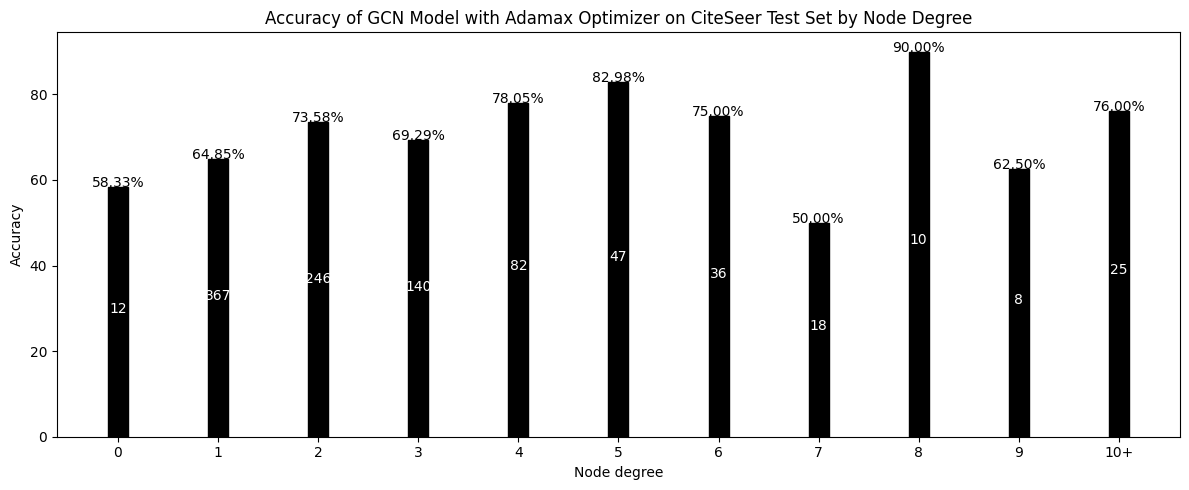

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return (sum(y_pred == y_true) / len(y_true))*100

# Get model's classifications
out = gcn(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.test_mask.numpy()]

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
pred = probas.argmax(dim=1)

# Test data
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Accuracy for degrees between 0 and 5
for i in range(0, 10):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(predicted_labels[mask], true_labels[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 10
mask = np.where(degrees > 10)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy')
plt.bar(['0','1','2','3','4','5','6','7','8','9','10+'], accuracies, width=0.2, color='black', edgecolor='black')
for i in range(0, 11):
    plt.text(i, accuracies[i], f'{accuracies[i]:.2f}%', ha='center', color='black')
for i in range(0, 11):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

plt.title('Accuracy of GCN Model with Adamax Optimizer on CiteSeer Test Set by Node Degree')
plt.tight_layout()
plt.savefig('GCN_CiteSeer_Adamax_Accuracy_by_Degree.png')

plt.show()